In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [2]:
data_dir = '17flowers'
image_size = (128, 128) # Images will be resized to 128 by 128
batch_size = 40
num_classes = 17

In [3]:
### DATA LOADING AND PREPROCESSING
# Load the data and labels
data = []
labels = []
class_names = sorted(os.listdir(os.path.join(data_dir))) # Read the class names
# print("Class name: ", class_names)

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name) # Path to directory
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file) # Path to the image
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=image_size) # Load and resize the image
        img = tf.keras.preprocessing.image.img_to_array(img) # Convert the image to an array
        
        # Append the image and the class label to the respective lists
        data.append(img)
        labels.append(class_name)

        
data = np.array(data)
# print(len(data))

labels = np.array(labels)
# print("Labels: ", labels)

In [4]:
### DATA CONVERSION AND SPLITTING
### Convert class names to integer labels
# Create a mapping from class name to integer labels
label_to_index = {label: i for i, label in enumerate(class_names)}
print("label_to_index: ", label_to_index)

# Converts class names to integer labels
labels = np.array([label_to_index[label] for label in labels])
print("labels: ", labels)
print("labels length: ", len(labels))

# Split data into training, validation, and testing sets
# 70% will be used for training
x_train, x_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
print("x_train size: ", len(x_train))
print("x_temp size: ", len(x_temp))


# SPlit the data from above validations and testing (15% each now)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
print("x_val size: ", len(x_val))
print("y_val size: ", len(y_val))


label_to_index:  {'Bluebell': 0, 'Buttercup': 1, 'Coltsfoot': 2, 'Cowslip': 3, 'Crocus': 4, 'Daffodil': 5, 'Daisy': 6, 'Dandelion': 7, 'Fritillary': 8, 'Iris': 9, 'Lily Valley': 10, 'Pansy': 11, 'Snowdrop': 12, 'Sunflower': 13, 'Tigerlily': 14, 'Tulip': 15, 'Windflower': 16}
labels:  [ 0  0  0 ... 16 16 16]
labels length:  1360
x_train size:  952
x_temp size:  408
x_val size:  204
y_val size:  204


In [5]:
# Convert integer labels to one-hot encoded labels
# To respresent class labels as categorical vectors
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("y_train: ", y_train)

y_train:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [6]:
# Create an iterator for the dataset
train_iterator = iter(x_train)

# Get the first batch
first_batch = next(train_iterator)

batch_shape = first_batch[0].shape
print("Shape of batch:", batch_shape)

# Get the size (dimensions) of the first image
image_height, image_width, num_channels = first_batch.shape
print("Image size (height x width x channels):", image_height, "x", image_width, "x", num_channels)

# Check the size of the first batch
batch_height = len(first_batch[0])  # Assuming the first element of the batch is the images
print("Height of the images in the first batch:", batch_size)


Shape of batch: (128, 3)
Image size (height x width x channels): 128 x 128 x 3
Height of the images in the first batch: 40


In [7]:
### DATA NORMALIZATION
# The RGB channel values are in the [0, 255] range.
# This is not ideal for a neural network
# Normalize the pixel values to [0, 1]

# print (x_train)
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0
# print (x_train)

In [8]:
# Build the model with regularization
inputs = Input(shape=(image_size[0], image_size[1], 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((4, 4))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((4, 4))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((4, 4))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.8)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856 

In [9]:
# Compile the model using Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Train the model
epochs = 30
hist = model.fit(x_train, y_train,
          validation_data=(x_val, y_val),
          batch_size=batch_size,
          epochs=epochs)

Epoch 1/30
24/24 [==============================] - 8s 248ms/step - loss: 2.8404 - accuracy: 0.0567 - val_loss: 2.8174 - val_accuracy: 0.1127
Epoch 2/30
24/24 [==============================] - 5s 201ms/step - loss: 2.7902 - accuracy: 0.0851 - val_loss: 2.6943 - val_accuracy: 0.1078
Epoch 3/30
24/24 [==============================] - 5s 195ms/step - loss: 2.6970 - accuracy: 0.1229 - val_loss: 2.5345 - val_accuracy: 0.1716
Epoch 4/30
24/24 [==============================] - 5s 189ms/step - loss: 2.5759 - accuracy: 0.1376 - val_loss: 2.3982 - val_accuracy: 0.2206
Epoch 5/30
24/24 [==============================] - 5s 188ms/step - loss: 2.4869 - accuracy: 0.1670 - val_loss: 2.2894 - val_accuracy: 0.2402
Epoch 6/30
24/24 [==============================] - 5s 191ms/step - loss: 2.4183 - accuracy: 0.1880 - val_loss: 2.2177 - val_accuracy: 0.3039
Epoch 7/30
24/24 [==============================] - 5s 194ms/step - loss: 2.2921 - accuracy: 0.2258 - val_loss: 2.0805 - val_accuracy: 0.3431
Epoch 

# Plot Accuracy

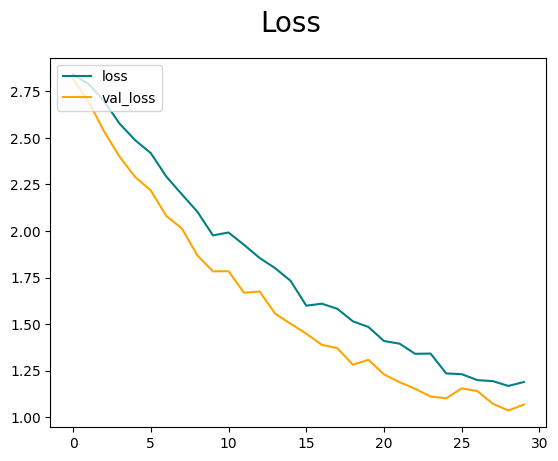

In [11]:
# Visualise our loss
# Loss: measure of how well a model's predictions match the true target values in the training dataset. 
# The goal of training a machine learning model is to minimize the loss function, as this indicates that the model is making more accurate predictions.
# When training a model, it starts with some initial set of parameters (weights and biases) and makes predictions on the training data. 
# The loss function then quantifies the difference between these predictions and the actual target values. 
# The larger the difference, the higher the loss, indicating that the model is performing poorly.
from matplotlib import pyplot as plt

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss') # Training Loss
plt.plot(hist.history['val_loss'], color='orange', label='val_loss') # Validation Loss
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Our validation loss is increasing so the model is overfitting here (as mentioned in the video)
# Might need to perform some regularization as model is overfitting here

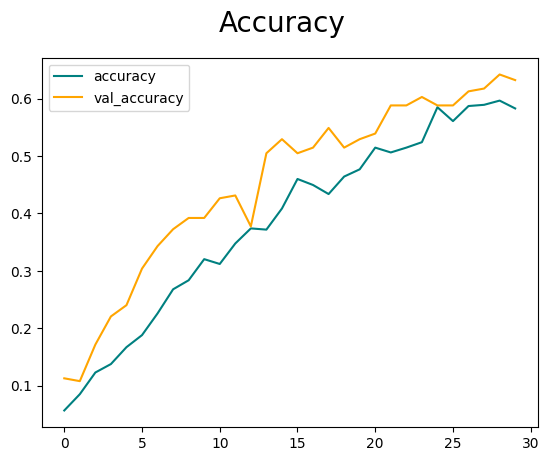

In [12]:
# Visualise the accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [15]:
# Save the model
from tensorflow.keras.models import load_model
# model.save(os.path.join('models\\Regularization', 'DorpoutTest4.keras'))

# Making Predictions

In [334]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [335]:
new_image_paths = ['C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\Bluebell.jpg', 'C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\Buttercup.jpg', 'C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\Coltsfoot.jpg', 'C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\Cowslip.jpg', 'C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\Crocus.jpg', 'C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\Daffodil.jpg', 'C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\Daisy.jpg', 'C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\Dandelion.jpg', 'C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\Fritillary.jpg', 'C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\Iris.jpg', 'C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\LilValley.jpg', 'C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\Pansy.jpg', 'C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\Snowdrop.jpg', 'C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\Sunflower.jpg', 'C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\Tigerly.jpg', 'C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\Tulip.jpg', 'C:\\Users\\usman\\ML\\BeeGPTModel\\TestPics\\Windflower.jpg']
new_images = []  # Store preprocessed images here
for image_path in new_image_paths:
    new_image = load_img(image_path, target_size=image_size)
    new_image = img_to_array(new_image)
    new_image = new_image / 255.0
    new_images.append(new_image)

new_images = np.array(new_images)

# Make predictions for all new images
predictions = model.predict(new_images)

1/1 [==============================] - 1s 897ms/step


In [139]:
predicted_labels = np.argmax(predictions, axis=1)
class_labels = list(label_to_index.keys())  # Get class labels from the label-to-index mapping
predicted_classes = [class_labels[i] for i in predicted_labels]

In [140]:
print(predicted_classes) ## Can't recognise tulips???

['Bluebell', 'Buttercup', 'Tulip', 'Cowslip', 'Bluebell', 'Cowslip', 'Crocus', 'Fritillary', 'Fritillary', 'Bluebell', 'Snowdrop', 'Crocus', 'Snowdrop', 'Cowslip', 'Tigerlily', 'Fritillary', 'Fritillary']
